# Model validation on SH3 and PDZ

## Libraries, functions and dictionaries

In [1]:
import sys, os

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import mdtraj as md
import random
import seaborn as sns
import re
#import ptitprince as pt

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool
from catboost.datasets import titanic
from graphviz import Digraph
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

In [2]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_3L_1LC={"Ter":'*',"Gap":'-',"ALA":'A',"CYS":'C',"ASP":'D',"GLU":'E',"PHE":'F',"GLY":'G',"HIS":'H',"ILE":'I',"LYS":'K',"LEU":'L',"MET":'M',"ASN":'N',"PRO":'P',"GLN":'Q',"ARG":'R',"SER":'S',"THR":'T',"VAL" :'V',"TRP":'W',"TYR":'Y'}

alphabetAA_to_classes={'A':1,'C':2,'D':3,'E':3,'F':1,'G':4,'H':3,'I':1,'K':3,'L':1,'M':1,'N':2,'P':4,'Q':2,'R':3,'S':2,'T':2,'V':1,'W':1,'Y':1}
alphabetclasses_to_AA={v: k for k,v in alphabetAA_to_classes.items()}

AA_ddsp_number={'H' :0,'B' : 1,'E' : 2,'G' : 3,'I' : 4,'T' : 5,'S' : 6,' ' : 7}
AA_number_ddsp={v: k for k,v in AA_ddsp_number.items()}

AA_ddsp_number_simp={'H' :0,'E' : 1,'C' : 2}
AA_number_ddsp_simp={v: k for k,v in AA_ddsp_number.items()}

AA_to_hydrophobicity_scores={'A':44,'C':50,'D':-37,'E':-12,'F':96,'G':0,'H':-16,'I':100,'K':-30,'L':99,'M':74,'N':-35,'P':-46,'Q':-14,'R':-20,'S':-6,'T':13,'V':78,'W':90,'Y':57}

### Load functions

In [3]:
def remove_WT_score(score,WT_seq):
    for i in range(len(WT_seq)):
        score[i,alphabetAA_L_D[WT_seq[i]]-1]=np.nan
    return score

In [4]:
def load_data_V2(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][len(mutation_load[i])-1]!= '*' :
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

### General functions

In [5]:
def normalize_score(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.percentile(scores[~np.isnan(scores)],5)
    c_max_act=np.percentile(scores[~np.isnan(scores)],95)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [6]:
def normalize_minmax(scores):
    normalized_scores=np.copy(scores)
    c_min_act=np.amin(scores[~np.isnan(scores)])
    c_max_act=np.amax(scores[~np.isnan(scores)])
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=(scores[i,j]-c_min_act)/(c_max_act-c_min_act)
                                  
    return normalized_scores

In [7]:
def normalize_fermi(scores):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            normalized_scores[i,j]=1/(sp.exp(scores[i,j]-2)+1)                 
    return normalized_scores

In [8]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [9]:
def position_mean(score):
    score_mean=np.zeros(score.shape[0],dtype=float)
    for i in range(score.shape[0]):
        count=0
        flag_nan=True
        for j in range(score.shape[1]):
            if np.isnan(score[i,j])==False:
                flag_nan=False
                score_mean[i]+=score[i,j]
                count+=1
            else:
                pass
        if flag_nan==True:
            score_mean[i]=np.nan
        score_mean[i]/=count
        
    return score_mean

In [10]:
def score_histogram(score,nbin,color,label_x,norm_bool,thr):

    counts, bins = np.histogram(score[~np.isnan(score)],bins=nbin)
    if norm_bool=='Density':
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color, alpha=0.7,edgecolor="black",density=True)
        plt.ylabel('Normalized counts',fontsize=20)
    elif norm_bool=='True':
        
        norm= counts / np.linalg.norm(counts)
        plt.hist(bins[:-1], bins, weights=norm, facecolor=color, alpha=0.7,edgecolor="black")
        plt.ylabel('Normalized counts',fontsize=20)
    else:
        n, bins, patches = plt.hist(score[~np.isnan(score)], bins=nbin, facecolor=color,edgecolor="black")
        plt.ylabel('Counts',fontsize=20)

    plt.xlabel(label_x,fontsize=20)
    plt.xticks(fontsize=18)
    plt.grid(axis="y",alpha=0.4,linestyle='--')
    sum_unstable=0
    for i in range(len(bins)-1):
        if bins[i+1] < thr:
            sum_unstable+=counts[i]
    print('Wt-like variants:',np.sum(counts)-sum_unstable, ' (', (np.sum(counts)-sum_unstable)/np.sum(counts) ,')')
    
    #plt.show()

In [11]:
def heatmap_IBS(prediction,variant_map,WT):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1

    fig, ax = plt.subplots(figsize=(16,6))
    ylabels=[ alphabetAA_D_L[i] for i in range(1,21)]
    
    ax.imshow(np.transpose(scores), aspect = 'auto', cmap=mpl.colors.ListedColormap(["white","#56b4e9"]))

    ax.set_yticks([i for i in range(0,20)])
    ax.set_yticklabels(ylabels,fontsize=15)
    ax.tick_params(axis='x', which='major', labelsize=15)
        
    tmp=np.empty((len(WT),20),dtype=float)
    tmp[:]=np.inf
    for i in range(0,len(WT)):
        tmp[i,alphabetAA_L_D[WT[i]]-1]=1
    plt.imshow(tmp.T, cmap='Accent', aspect = 'auto')
    
    plt.grid(axis='both',which='both',alpha=0.4)
    plt.ylabel("mutation",fontsize=16)
    plt.xlabel("residue",fontsize=16)

    plt.ylim(-0.5,19.5)

In [12]:
def ratio_variants(mave_funct,mave_abd):
    ratio=np.copy(mave_funct)
    ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(mave_funct[i,j]) or np.isnan(mave_abd[i,j]):
                pass
            else:
                if mave_abd[i,j]==0.0:
                    ratio[i,j]=mave_funct[i,j]/0.0000001
                else:
                    ratio[i,j]=mave_funct[i,j]/mave_abd[i,j]
    sig_ratio=np.copy(ratio)
    sig_ratio[:]=np.nan
    for i in range(ratio.shape[0]):
        for j in range(ratio.shape[1]):
            if np.isnan(ratio[i,j])!=True:
                sig_ratio[i,j]=1/(1+np.exp(-(ratio[i,j]-1)))

    return sig_ratio

In [13]:
def MCC_test_subset(prediction,test):
    TP=0
    FP=0
    total=0
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if int(test[i])==1:
                total+=1
    precision=TP/(TP+FP)
    recall=TP/total
    mcc=np.sqrt(abs(precision*recall))
    
    return precision,recall,mcc                 

In [14]:
def AUC_subset(prediction,test):
    TP=0
    FP=0
    FN=0
    TN=0
    
    for i in range(len(prediction)):
        if np.isnan(prediction[i])!= True and np.isnan(test[i])!=True:
            if prediction[i]==1:
                if int(prediction[i])==int(test[i]):
                    TP+=1
                else:
                    FP+=1
            if prediction[i]==0:
                if int(prediction[i])==int(test[i]):
                    TN+=1
                else:
                    FN+=1 
                    
    TPR=TP/(TP+FN)
    FPR=FP/(FP+TN)
    
    return [TPR,FPR]

In [15]:
def retrieve_residue_label_pred_training(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage_mode=np.zeros((len(WT),2),dtype=float)
    
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            count_1=0
            for j in range(scores.shape[1]):
                if scores[i,j]==1:
                    count_1+=1
            percentage=count_1/count
            
            if percentage > percentage_threshold:
                pseudomode_value_class[i]=1
            else:
                pseudomode_value_class[i]=0
            
            percentage_mode[i,0]=percentage
            percentage_mode[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage_mode

In [16]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    count_pos=np.zeros((len(WT),4),dtype=float)
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage=np.zeros((len(WT),2),dtype=float)
        
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            for j in range(scores.shape[1]):
                    if np.isnan(scores[i,j])!=True:
                        count_pos[i,int(scores[i,j])]+=1
            count_pos=count_pos/count
            if np.any(count_pos[i,:]>=0.50):
                pseudomode_value_class[i]=np.argmax(count_pos[i,:])
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),pseudomode_value_class[i])


            else:                
                pseudomode_value_class[i]=5
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),'else',pseudomode_value_class[i])
                ## 5 indicates mixed signal with no predominat mutation class
            
            percentage[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage

In [17]:
def pairplot_features(list_feature,name_features,namefile):
    df=pd.DataFrame(list_feature,columns=name_features)
    sns_plot=sns.pairplot(df)
    sns_plot.savefig(namefile)

In [18]:
def print_chimera_x_attribute_file(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            file.write("\t%s%d\t%f\n" % ('/A:',i+1,attribute[i]))
    file.close()

In [19]:
def print_chimera_x_attribute_file_SBI(attribute_check,attribute,file):
    file=open(file,"w+")
    file.write('%s\n%s\n%s\n%s\n' % ('#','#  Use this file to assign the attribute in Chimera with the','#  Define Attribute tool or the command defattr','#'))
    file.write('%s\n%s\n%s\n' % ( 'attribute: cbyvalue','match mode: 1-to-1', 'recipient: residues') )
    for i in range(len(attribute_check)):
        if np.isnan(attribute_check[i])==True:
            pass
        else:
            if attribute_check[i]==1.0:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,1))
            else:
                file.write("\t%s%d\t%f\n" % ('/A:',i+1,0))
    file.close()

In [20]:
def plot_attributes(pos,pred,variant_map,gemme,rosetta,wcn,gemme_n,rosetta_n):
    
    label_position=np.empty(20,dtype=float)
    label_position[:]=np.nan
    
    i=0
    for cord in variant_map:
        if cord[0]==pos:
            label_position[cord[1]]=prediction[i]
        i+=1
    
    fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(1,6,figsize=(9,4),gridspec_kw={"width_ratios" : [7,1,1,1,1,1], "wspace" : 0.4})
    cdict = {1: 'blue', 0: 'red'}
    glabel={1.0:'SBI',0.0:'non-SBI'}
    for g in np.unique(label_position):
        if np.isnan(g)!=True:
            ix = np.where(label_position == g)
            ax1.scatter(rosetta[pos,ix],gemme[pos,ix],c=cdict[g], label=[glabel[g]])
    
    ax2.bar(x=0.5,height=wcn[pos])
    ax3.bar(x=0.5,height=np.mean(gemme[pos,:][~np.isnan(gemme[pos,:])]))
    ax4.bar(x=0.5,height=np.mean(rosetta[pos,:][~np.isnan(rosetta[pos,:])]))   
    ax5.bar(x=0.5,height=gemme_n[pos])
    ax6.bar(x=0.5,height=rosetta_n[pos])
    
    
    ax1.set_title('variants classification')
    ax2.set_title('WCN')
    ax3.set_title(r'$\bar{G}$')
    ax4.set_title(r'$\bar{r}$')
    ax5.set_title(r'G_n')
    ax6.set_title(r'r_n')
    
    ax1.set_xlabel('rosetta_score',fontsize=13)
    ax1.set_ylabel('GEMME score',fontsize=13)
    ax1.set_xlim(6,-1)
    ax1.set_ylim(-7,1)
    ax2.set_ylim(0,15)
    ax3.set_ylim(0,-8)
    ax4.set_ylim(0,6)
    ax5.set_ylim(0,-8)
    ax6.set_ylim(0,6)
    
    
    ax2.set_xticks([],[])
    ax3.set_xticks([],[])
    ax4.set_xticks([],[])
    ax5.set_xticks([],[])
    ax6.set_xticks([],[])
    ax2.set_xlim(0.1,0.9)
    
    
    
    ax1.legend()

In [21]:
def results_plot(MCC,AUC,name_models):
    
    fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(14,4))
    
    cdict = {1: '#355070', 2: '#6D597A',2:'#B56576',3 :'#a4d600',4:'#a47f4b',5:'#EAAC8B',6:'#4a944f',7:"#F95738"}
    for g in range(0,7):
        ax1.scatter(AUC[g,1],AUC[g,0],c=cdict[g+1])
    ax1.plot([0, 1], [0, 1], transform=ax1.transAxes,ls=':')
    ax1.set_xlabel('FPR',fontsize=13)
    ax1.set_ylabel('TPR',fontsize=13)
    
    for g in range(0,7):
        ax2.scatter(MCC[g,0],MCC[g,1],c=cdict[g+1], label=g+1)
    #ax2.scatter(MCC[:,0],MCC[:,1],c=color_class)
    
    ax2.set_xlabel('Precision',fontsize=13)
    ax2.set_ylabel('Recall',fontsize=13)
    ax2.legend(loc='lower right')
    
    cbar=[cdict[i] for i in range(1,8)]
    ax3.bar(name_models,MCC[:,2],color=cbar)
    ax3.set_ylabel('MCC',fontsize=13)


In [22]:
def print_percentage_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    print(f' SBI variants: {count_SBI} out of {len(pred)} ({count_SBI/len(pred)*100:.2f}%) ')
    
    perc_variants=count_SBI/len(pred)*100
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    print(f' SBI residues: {count_SBI} out of {effective_pos} ({count_SBI/effective_pos*100:.2f}%) ')
    
    return [perc_variants, count_SBI/effective_pos*100]

In [23]:
def print_numbers_prediction(pred,mode_pred,WT,WT_ros):
    effective_pos=0
    for i in range(len(WT)):
        if WT[i]==WT_ros[i]:
            effective_pos+=1
    count_SBI=0
    for i in pred:
        if i ==1:
            count_SBI+=1
    
    variants=count_SBI
    
    count_SBI=0
    for i in mode_pred:
        if i==1:
            count_SBI+=1
    
    return [variants, count_SBI]

In [24]:
def count_variants_regions(class_matrix):
#count the variants present in each region in the input matrix
    
    count_reg=np.zeros((4,1),dtype=int)
    
    for i in range(class_matrix.shape[0]):
        for j in range(class_matrix.shape[1]):
            if np.isnan(class_matrix[i,j]) == False:
                count_reg[int(class_matrix[i,j])-1]+=1
                
    return count_reg

### setup ML functions

In [25]:
def blosum62_score(WT,scores):
    blosum_prot=np.empty((len(WT),20),dtype=float)
    
    for i in range(len(WT)):
        for j in range(20):
            blosum_prot[i,j]=scores[alphabetAA_L_D[WT[i]]-1,j]
            
    return blosum_prot

In [26]:
def secondary_structure_cat(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=False)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    
    for i in range(len(ss_labels[0,:])):
        ss_ret_labels[int(str(chainA_top.residue(i))[3:])-1]=AA_ddsp_number[ss_labels[0,i]]
    
    return ss_ret_labels
    

In [27]:
def secondary_structure_cat_simp(pdb_loc,WT):
    pdb=md.load(pdb_loc)
    topology = pdb.topology
    chainA = topology.select('chainid 0  and protein')
    pdb_chainA= pdb.atom_slice(chainA)
    
    chainA_top=pdb_chainA.topology
    
    ss_labels=md.compute_dssp(pdb_chainA,simplified=True)

    ss_ret_labels=np.empty(len(WT),dtype=float)
    ss_ret_labels[:]=np.nan
    count=1
    for j in range(len(WT)):
        if WT[j]!='-':
            for i in range(len(ss_labels[0,:])):
                if count==int(str(chainA_top.residue(i))[3:]):
                    ss_ret_labels[j]=AA_ddsp_number_simp[ss_labels[0,i]]
            count+=1
    return ss_ret_labels
    

In [28]:
def WCN(pdb_loc,scheme_e,WT):
    r0=7.0
    pdb=md.load(pdb_loc)
    topology=pdb.topology
    chainA=topology.select('chainid 0 and protein')
    pdb_chain0=pdb.atom_slice(chainA)
    pdb_dist,pdb_rp=md.compute_contacts(pdb_chain0,scheme=scheme_e,periodic=False)
    
    cm= md.geometry.squareform(pdb_dist,pdb_rp)[0]
    wcn=np.zeros((len(WT)),dtype=float)
    
    cm_adj=np.empty((len(WT),len(WT)),dtype=float)
    cm_adj[:]=np.nan
    chainA_top=pdb_chain0.topology
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i==0 and j==0:
                print(str(chainA_top.residue(i)))
            cm_adj[int(str(chainA_top.residue(i))[3:])-1,int(str(chainA_top.residue(j))[3:])-1]=cm[i,j]
    for i in range(len(WT)):
        nan_flag=True
        for j in range(len(WT)):
            if np.isnan(cm_adj[i,j])!=True and cm_adj[i,j]!=0.0:
                nan_flag=False
                wcn[i]+=(1-(cm_adj[i,j]*10/r0)**6)/(1-(cm_adj[i,j]*10/r0)**12)
        if nan_flag==True:
            wcn[i]=np.nan
    return wcn

In [29]:
def neighbor_scores(score,ext_range):
    score_neighborhood=np.zeros(len(score),dtype=float)
    for i in range(len(score)):
        if np.isnan(score[i])!=True:
            count_nan=0
            if i==0:
                for j in range(1,ext_range+1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range:    
                    score_neighborhood[i]/=(ext_range)
                else:
                    score_neighborhood[i]=np.nan

            elif i==(len(score)-1):
                for j in range(len(score)-1-ext_range,len(score)-1):
                    if np.isnan(score[j])==False:
                        score_neighborhood[i]+=score[j]
                    else:
                        count_nan+=1
                if count_nan!=ext_range: 
                    score_neighborhood[i]/=ext_range
                else:
                    score_neighborhood[i]=np.nan                
            elif i<ext_range:
                for j in range(0,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(i+ext_range):    
                    score_neighborhood[i]/=(i+ext_range)
                else:
                    score_neighborhood[i]=np.nan                        

            elif i>(len(score)-1-ext_range):
                for j in range(i-ext_range,len(score)):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(len(score)-i+ext_range):                     
                    score_neighborhood[i]/=(len(score)-i+ext_range)
                else:
                    score_neighborhood[i]=np.nan  
            else:
                for j in range(i-ext_range,i+ext_range+1):
                    if j!=i:
                        if np.isnan(score[j])==False:
                            score_neighborhood[i]+=score[j]
                        else:
                            count_nan+=1
                if count_nan!=(2*ext_range):  
                    score_neighborhood[i]/=(2*ext_range)
                else:
                    score_neighborhood[i]=np.nan             
        else:
            score_neighborhood[i]=np.nan
    return score_neighborhood

In [30]:
def label_category(output,threshold):
    labels=[]
    if output.ndim==1:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(len(output)):
            if output[i]<threshold:
                labels[i]=0
            else:
                labels[i]=1
    else:
        labels=np.copy(output)
        labels[:]=np.nan
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                if output[i,j]<threshold:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    return labels

In [31]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [32]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [33]:
def features_validation(list_features_x,WT):
    
    X=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                

                if cond==True:
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    mapping_pos.append([i,j])
        
    return np.array(X),mapping_pos        

In [34]:
def binary_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                else:
                    labels[i,j]=0
    
    return labels

In [35]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=3
                else:
                    labels[i,j]=0
    
    return labels

## Load trained model

In [36]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [37]:
cat.load_model('../catboost_model/cat_trained_24jun22.cbm')

## Load validation dataset

### P62993 and P78352

In [38]:
P62993_WT_sequence="MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDGFIPKNYIEMKPHPWFFGKIPRAKAEEMLSKQRHDGAFLIRESESAPGDFSLSVKFGNDVQHFKVLRDGAGKYFLWVVKFNSLNELVDYHRSTSVSRNQQIFLRDIEQVPQQPTYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGMFPRNYVTPVNRNV"
P62993_WT_rosetta ="MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDGFIPKNYIEMKPHPWFFGKIPRAKAEEMLSKQRHDGAFLIRESESAPGDFSLSVKFGNDVQHFKVLRDGAGKYFLWVVKFNSLNELVDYHRSTSVSRNQQIFLRDIEQVPQQPTYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGMFPRNYVTPVNRNV"
P62993_WT_exp     ="--------------------------------------------------------------------------------------------------------------------------------------------------------------TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGMFPRNYVTPVN---"


In [39]:
P62993_exp_starting_pos=158

In [40]:
P78352_WT_sequence="MDCLCIVTTKKYRYQDEDTPPLEHSPAHLPNQANSPPVIVNTDTLEAPGYELQVNGTEGEMEYEEITLERGNSGLGFSIAGGTDNPHIGDDPSIFITKIIPGGAAAQDGRLRVNDSILFVNEVDVREVTHSAAVEALKEAGSIVRLYVMRRKPPAEKVMEIKLIKGPKGLGFSIAGGVGNQHIPGDNSIYVTKIIEGGAAHKDGRLQIGDKILAVNSVGLEDVMHEDAVAALKNTYDVVYLKVAKPSNAYLSDSYAPPDITTSYSQHLDNEISHSSYLGTDYPTAMTPTSPRRYSPVAKDLLGEEDIPREPRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEYSRFEAKIHDLREQLMNSSLGSGTASLRSNPKRGFYIRALFDYDKTKDCGFLSQALSFRFGDVLHVIDASDEEWWQARRVHSDSETDDIGFIPSKRRVERREWSRLKAKDWGSSSGSQGREDSVLSYETVTQMEVHYARPIIILGPTKDRANDDLLSEFPDKFGSCVPHTTRPKREYEIDGRDYHFVSSREKMEKDIQAHKFIEAGQYNSHLYGTSVQSVREVAEQGKHCILDVSANAVRRLQAAHLHPIAIFIRPRSLENVLEINKRITEEQARKAFDRATKLEQEFTECFSAIVEGDSFEEIYHKVKRVIEDLSGPYIWVPARERL"
P78352_WT_PDZ3    ="--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------REPRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEY---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------"
P78352_WT_rosetta ="--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------REPRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKPEEY---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------"
P78352_WT_exp     ="----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------PRRIVIHRGSTGLGFNIVGGEDGEGIFISFILAGGPADLSGELRKGDQILSVNGVDLRNASHEQAAIALKNAGQTVTIIAQYKP------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------"

In [41]:
P78352_exp_starting_pos=310

#### EXP data

##### table s6 compressed into an array to reduce the save

In [65]:
P62993_abundance=np.load('../score_maves/Faure_experimental_as_arrays.npz')['P62993_abundance']

In [66]:
P62993_binding=np.load('../score_maves/Faure_experimental_as_arrays.npz')['P62993_binding']

In [67]:
P62993_abundance_median=np.load('../score_maves/Faure_experimental_as_arrays.npz')['P62993_abundance_median']

In [68]:
P62993_binding_median=np.load('../score_maves/Faure_experimental_as_arrays.npz')['P62993_binding_median']

### Statistics
data imported from notebook (2/2)

##### table S8

In [58]:
SI_pred_df=pd.read_excel('../score_maves/faure_SI_8_prediction.xlsx')

In [59]:
SI_pred_df.query('protein == "PSD95-PDZ3" and mut_order==1')

,Pos_ref,id,id_ref,Pos,mut_order,f_dg_pred,f_ddg_pred,f_ddg_pred_sd,b_dg_pred,b_ddg_pred,...,SS,Pos_class,protein,WT_AA,Mut,b_ddg_wposmeanabs,b_ddg_wposse,allosteric,orthosteric,allosteric_mutation
1047,311.0,P1R,P311R,1.0,1,-1.131053,0.178328,0.046726,-0.528678,0.177978,...,NaN,surface,PSD95-PDZ3,P,R,0.137248,0.005097,NaN,NaN,0.0
1048,311.0,P1D,P311D,1.0,1,-1.091338,0.218044,0.080678,-0.564490,0.142166,...,NaN,surface,PSD95-PDZ3,P,D,0.137248,0.005097,NaN,NaN,0.0
1049,311.0,P1E,P311E,1.0,1,-1.830139,-0.520758,0.087523,-0.733387,-0.026731,...,NaN,surface,PSD95-PDZ3,P,E,0.137248,0.005097,NaN,NaN,0.0
1050,311.0,P1C,P311C,1.0,1,-1.319006,-0.009625,0.035818,-0.482355,0.224301,...,NaN,surface,PSD95-PDZ3,P,C,0.137248,0.005097,NaN,NaN,0.0
1051,311.0,P1Y,P311Y,1.0,1,-0.657792,0.651589,0.060221,-0.527264,0.179391,...,NaN,surface,PSD95-PDZ3,P,Y,0.137248,0.005097,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,394.0,P84S,P394S,84.0,1,-1.560937,-0.251556,0.066945,-0.699488,0.007168,...,helix,surface,PSD95-PDZ3,P,S,0.145760,0.007503,NaN,NaN,0.0
2630,394.0,P84R,P394R,84.0,1,-1.045501,0.263880,0.041271,-0.777027,-0.070371,...,helix,surface,PSD95-PDZ3,P,R,0.145760,0.007503,NaN,NaN,0.0
2631,394.0,P84F,P394F,84.0,1,-1.762454,-0.453073,0.060712,-0.549214,0.157441,...,helix,surface,PSD95-PDZ3,P,F,0.145760,0.007503,NaN,NaN,0.0
2632,394.0,P84N,P394N,84.0,1,-0.425518,0.883863,0.170049,-1.144626,-0.437970,...,helix,surface,PSD95-PDZ3,P,N,0.145760,0.007503,NaN,NaN,0.0


In [60]:
SI_pred_df.query('protein == "GRB2-SH3" and mut_order==1')

,Pos_ref,id,id_ref,Pos,mut_order,f_dg_pred,f_ddg_pred,f_ddg_pred_sd,b_dg_pred,b_ddg_pred,...,SS,Pos_class,protein,WT_AA,Mut,b_ddg_wposmeanabs,b_ddg_wposse,allosteric,orthosteric,allosteric_mutation
2635,1.0,T1V,T1V,1.0,1,-0.857212,-0.025741,0.007187,-1.362525,-0.317564,...,NaN,surface,GRB2-SH3,T,V,0.055075,0.004323,NaN,NaN,0.0
2636,1.0,T1N,T1N,1.0,1,-0.852085,-0.020614,0.016236,-0.793679,0.251282,...,NaN,surface,GRB2-SH3,T,N,0.055075,0.004323,NaN,NaN,0.0
2637,1.0,T1M,T1M,1.0,1,-0.945146,-0.113675,0.004986,-1.135068,-0.090106,...,NaN,surface,GRB2-SH3,T,M,0.055075,0.004323,NaN,NaN,0.0
2638,1.0,T1I,T1I,1.0,1,-0.863007,-0.031536,0.009737,-0.969562,0.075400,...,NaN,surface,GRB2-SH3,T,I,0.055075,0.004323,NaN,NaN,0.0
2639,1.0,T1S,T1S,1.0,1,-0.738337,0.093133,0.009241,-1.056986,-0.012024,...,NaN,surface,GRB2-SH3,T,S,0.055075,0.004323,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3686,56.0,N56E,N56E,56.0,1,-0.969155,-0.137684,0.028009,-1.135839,-0.090877,...,NaN,surface,GRB2-SH3,N,E,0.106237,0.004720,NaN,NaN,0.0
3687,56.0,N56A,N56A,56.0,1,-0.581911,0.249560,0.018123,NaN,NaN,...,NaN,surface,GRB2-SH3,N,A,0.106237,0.004720,NaN,NaN,NaN
3688,56.0,N56L,N56L,56.0,1,-0.427307,0.404164,0.025309,NaN,NaN,...,NaN,surface,GRB2-SH3,N,L,0.106237,0.004720,NaN,NaN,NaN
3689,56.0,N56P,N56P,56.0,1,-0.615760,0.215711,0.038178,NaN,NaN,...,NaN,surface,GRB2-SH3,N,P,0.106237,0.004720,NaN,NaN,NaN


In [61]:
P62993_binding_ddg=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_binding_ddg[:]=np.nan
P78352_binding_ddg=np.empty((len(P78352_WT_sequence),20),dtype=float)
P78352_binding_ddg[:]=np.nan

In [62]:
P62993_abundance_ddg=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_abundance_ddg[:]=np.nan
P78352_abundance_ddg=np.empty((len(P78352_WT_sequence),20),dtype=float)
P78352_abundance_ddg[:]=np.nan

In [63]:
for i,n in SI_pred_df.query('protein == "GRB2-SH3" and mut_order==1').iterrows():
    P62993_binding_ddg[int(n['id_ref'][1:-1])+P62993_exp_starting_pos-1,alphabetAA_L_D[n['id_ref'][-1]]-1]=float(n['b_ddg_pred'])
    P62993_abundance_ddg[int(n['id_ref'][1:-1])+P62993_exp_starting_pos-1,alphabetAA_L_D[n['id_ref'][-1]]-1]=float(n['f_ddg_pred'])


In [69]:
for i,n in SI_pred_df.query('protein == "PSD95-PDZ3" and mut_order==1').iterrows():
    P78352_binding_ddg[int(n['id_ref'][1:-1])-1,alphabetAA_L_D[n['id_ref'][-1]]-1]=float(n['b_ddg_pred'])
    P78352_abundance_ddg[int(n['id_ref'][1:-1])-1,alphabetAA_L_D[n['id_ref'][-1]]-1]=float(n['f_ddg_pred'])


In [70]:
P78352_abundance_ddg_norm=normalize_cutoff(P78352_abundance_ddg,-1,3)
P78352_binding_ddg_norm=normalize_cutoff(P78352_binding_ddg,-1,3)

In [71]:
P62993_abundance_ddg_norm=normalize_cutoff(P62993_abundance_ddg,-1,3)
P62993_binding_ddg_norm=normalize_cutoff(P62993_binding_ddg,-1,3)

In [72]:
P62993_abundance_ddg_median=np.nanmedian(P62993_abundance_ddg,axis=1)
P62993_binding_ddg_median=np.nanmedian(P62993_binding_ddg,axis=1)

In [73]:
P78352_abundance_ddg_median=np.nanmedian(P78352_abundance_ddg,axis=1)
P78352_binding_ddg_median=np.nanmedian(P78352_binding_ddg,axis=1)

### P62993 classification ddgs experimental

In [74]:
P62993_exp_variant_label=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_exp_variant_label[:]=np.nan

In [75]:
# Assign the color to the variant based on its position in the 2d combined histogram

#wt like = 0
#sbi = 1
#total loss = 2

y_threshold=1
x_threshold=1

for i in range(P62993_exp_variant_label.shape[0]):
    for j in range(P62993_exp_variant_label.shape[1]):
        if np.isnan(P62993_binding_ddg_norm[i,j]) or np.isnan(P62993_abundance_ddg_norm[i,j]):
            pass
        else:
            if P62993_binding_ddg_norm[i,j] <= y_threshold:
                if P62993_abundance_ddg_norm[i,j] <= x_threshold:
                    P62993_exp_variant_label[i,j]=0
                else:
                    P62993_exp_variant_label[i,j]=2
            else:
                if P62993_abundance_ddg_norm[i,j] <= x_threshold:
                    P62993_exp_variant_label[i,j]=1
                else:
                    P62993_exp_variant_label[i,j]=2

In [76]:
P62993_exp_residue_label=np.empty((len(P62993_WT_sequence),1),dtype=float)
P62993_exp_residue_label[:]=np.nan

In [77]:
# Assign the color to the variant based on its position in the 2d combined histogram

#wt like = 0
#sbi = 1
#total loss = 2

y_threshold=1
x_threshold=1

for i in range(P62993_exp_residue_label.shape[0]):
        if np.isnan(P62993_binding_ddg_median[i]) or np.isnan(P62993_abundance_ddg_median[i]):
            pass
        else:
            if P62993_binding_ddg_median[i] <= y_threshold:
                if P62993_abundance_ddg_median[i] <= x_threshold:
                    P62993_exp_residue_label[i]=0
                else:
                    P62993_exp_residue_label[i]=2
            else:
                if P62993_abundance_ddg_median[i] <= x_threshold:
                    P62993_exp_residue_label[i]=1
                else:
                    P62993_exp_residue_label[i]=2

### Computational Data

#### Co-evolution

In [79]:
P62993_GEMME=load_data_V2('../scores_GEMME/prism_gemme_P62993.txt',P62993_WT_sequence)
P62993_GEMME=remove_WT_score(P62993_GEMME,P62993_WT_sequence)

In [80]:
P62993_GEMME_mean=position_mean(P62993_GEMME)

In [83]:
P78352_GEMME=load_data_V2('../scores_rosetta/prism_rosetta_ddg_P62993.txt',P78352_WT_sequence)
P78352_GEMME=remove_WT_score(P78352_GEMME,P78352_WT_sequence)

In [84]:
P78352_GEMME_mean=position_mean(P78352_GEMME)

In [90]:
P78352_GEMME_PDZ3=load_data_V2('../scores_GEMME/prism_gemme_P78352.txt',P78352_WT_PDZ3)
P78352_GEMME_PDZ3=remove_WT_score(P78352_GEMME_PDZ3,P78352_WT_sequence)

In [91]:
P78352_GEMME_PDZ3_mean=position_mean(P78352_GEMME_PDZ3)

####  Rosetta ddG

In [93]:
P62993_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P62993.txt",P62993_WT_rosetta,0)
P62993_rosetta_ddg=remove_WT_score(P62993_rosetta_ddg,P62993_WT_sequence)

In [94]:
P62993_rosetta_ddg_norm=normalize_cutoff(P62993_rosetta_ddg,0.0,5.0)

In [95]:
P62993_rosetta_ddg_mean=position_mean(P62993_rosetta_ddg_norm)

In [98]:
P78352_rosetta_ddg=load_data_V2("../scores_rosetta/prism_rosetta_ddg_P78352.txt",P78352_WT_rosetta,0)
P78352_rosetta_ddg=remove_WT_score(P78352_rosetta_ddg,P78352_WT_sequence)

In [99]:
P78352_rosetta_ddg_norm=normalize_cutoff(P78352_rosetta_ddg,0.0,5.0)

In [100]:
P78352_rosetta_ddg_mean=position_mean(P78352_rosetta_ddg_norm)

####  Cavity ddG

In [115]:
P62993_cavity_ddg=load_data_V2("../score_RaSP/prism_cavity_P62993_A.txt",P62993_WT_rosetta,0,column_score=2)
P62993_cavity_ddg=remove_WT_score(P62993_cavity_ddg,P62993_WT_sequence)

In [116]:
P62993_cavity_ddg_norm=normalize_cutoff(P62993_cavity_ddg,0.0,5.0)

In [117]:
P62993_cavity_ddg_mean=position_mean(P62993_cavity_ddg_norm)

Text(0, 0.5, 'cavity')

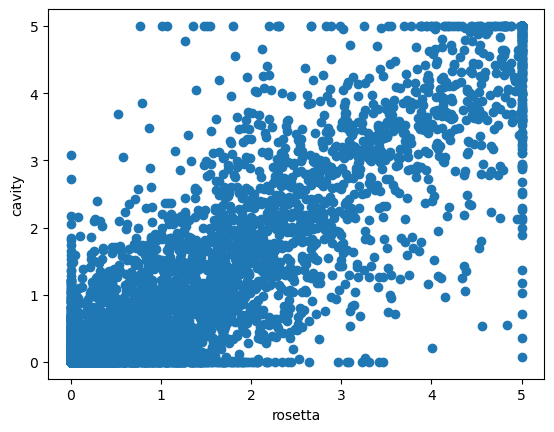

In [118]:
plt.scatter(P62993_rosetta_ddg_norm.flatten(),P62993_cavity_ddg_norm.flatten())
plt.xlabel('rosetta')
plt.ylabel('cavity')

Text(0, 0.5, 'cavity mean')

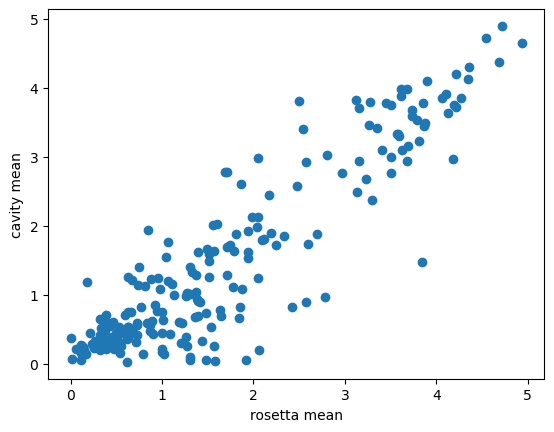

In [119]:
plt.scatter(P62993_rosetta_ddg_mean.flatten(),P62993_cavity_ddg_mean.flatten())
plt.xlabel('rosetta mean')
plt.ylabel('cavity mean')

#### Hydrophobicity

In [102]:
P62993_hydrophobicity_mut=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_hydrophobicity_mut[:]=np.nan

In [103]:
for i in range(len(P62993_WT_sequence)):
    for j in range(20):
        P62993_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

In [104]:
P78352_hydrophobicity_mut=np.empty((len(P78352_WT_sequence),20),dtype=float)
P78352_hydrophobicity_mut[:]=np.nan

In [198]:
for i in range(len(P78352_WT_sequence)):
    for j in range(20):
        P78352_hydrophobicity_mut[i,j]=AA_to_hydrophobicity_scores[alphabetAA_D_L[j+1]]

#### WCN

In [106]:
P62993_wcn=WCN('../pdbs/P62993_AF.pdb','ca',P62993_WT_sequence)

MET1


In [107]:
P78352_wcn=WCN('../pdbs/P78352_6qjj.pdb','ca',P78352_WT_sequence)

ARG309


#### Neigbor scores

In [120]:
P62993_rosetta_neigbor_scores=neighbor_scores(P62993_rosetta_ddg_mean,1)

P62993_GEMME_neigbor_scores=neighbor_scores(P62993_GEMME_mean,1)

P62993_cavity_neigbor_scores=neighbor_scores(P62993_cavity_ddg_mean,1)

In [121]:
P78352_rosetta_neigbor_scores=neighbor_scores(P78352_rosetta_ddg_mean,1)

P78352_GEMME_neigbor_scores=neighbor_scores(P78352_GEMME_mean,1)

## Predictions

###  P62993 predictions

In [110]:
P62993_X,P62993_map=features_validation([P62993_GEMME,P62993_rosetta_ddg_norm, P62993_GEMME_mean, P62993_rosetta_ddg_mean, P62993_hydrophobicity_mut,P62993_GEMME_neigbor_scores,P62993_rosetta_neigbor_scores,P62993_wcn],P62993_WT_sequence)

In [111]:
prediction=cat.predict(P62993_X)

In [112]:
P62993_variant_pred=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_variant_pred[:]=np.nan

for i,(n,m) in enumerate(zip(P62993_map,prediction)):
    P62993_variant_pred[n[0],n[1]]=m

In [113]:
P62993_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P62993_map,P62993_WT_sequence,0.50)

In [230]:
count=0
for i in prediction:
    if i==1:
        count+=1
print(count)

983


In [231]:
count=0
for i in prediction:
    if i==2:
        count+=1
print(count)

784


In [232]:
count=0
for i,n in enumerate(P62993_3mode_prediction):
    if n==1:
        print(P62993_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

E2, F9, T12, D15, F19, R21, V27, W36, K38, E40, P49, N51, Y52, I53, R67, R86, S88, S90, S96, S98, K100, K109, D113, G114, G116, V122, F125, S139, R142, Q144, I151, E171, E174, G180, D190, W193, G196, P206, Y209, 39


In [233]:
count=0
for i,n in enumerate(P62993_3mode_prediction):
    if n==0:
        print(P62993_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

I4, K6, Y7, D8, K10, A11, A13, D14, S18, K20, G22, D23, I24, L28, N29, E30, E31, C32, D33, Q34, N35, Y37, L41, N42, G43, K44, D45, F47, K50, E54, M55, K56, P57, H58, P59, F62, G63, K64, P66, A68, K69, E72, M73, S75, K76, R78, H79, D80, A82, E87, E89, A91, P92, G93, D94, F101, G102, N103, D104, Q106, L111, R112, A115, K117, W121, V123, K124, N126, N129, E130, D133, Y134, R136, S137, T138, S141, N143, Q145, F147, R149, E152, Q153, V154, P155, Q156, Q157, P158, T159, Y160, Q162, L164, F165, D166, D168, P169, Q170, D172, G173, G176, R178, R179, D181, F182, H184, M186, D187, N188, S189, P191, N192, K195, A197, H199, G200, Q201, T202, M204, R207, N208, T211, P212, V213, N214, R215, N216, V217, 126


###  P62993 cavity predictions

In [122]:
P62993_cavity_X,P62993_cavity_map=features_validation([P62993_GEMME,P62993_cavity_ddg_norm, P62993_GEMME_mean, P62993_cavity_ddg_mean, P62993_hydrophobicity_mut,P62993_GEMME_neigbor_scores,P62993_cavity_neigbor_scores,P62993_wcn],P62993_WT_sequence)

In [ ]:
prediction=cat.predict(P62993_cavity_X)

In [ ]:
P62993_variant_cavity_pred=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_variant_cavity_pred[:]=np.nan

for i,(n,m) in enumerate(zip(P62993_cavity_map,prediction)):
    P62993_variant_cavity_pred[n[0],n[1]]=m

In [ ]:
P62993_3mode_cavity_prediction,percentage=retrieve_residue_label_pred(prediction,P62993_cavity_map,P62993_WT_sequence,0.50)

In [ ]:
count=0
for i in prediction:
    if i==1:
        count+=1
print(count)

1066


In [ ]:
count=0
for i in prediction:
    if i==2:
        count+=1
print(count)

703


In [ ]:
count=0
for i,n in enumerate(P62993_3mode_cavity_prediction):
    if n==1:
        print(P62993_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

M1, F9, T12, E16, F19, R21, G22, K26, D33, W36, K38, E40, G43, P49, N51, Y52, I53, M55, G63, R67, E71, S88, S90, P92, G93, S96, S98, K100, V105, H107, F108, K109, G116, F125, S127, R136, S139, R142, D150, E171, E174, R179, G180, D190, W193, G196, C198, P206, Y209, 49


In [ ]:
count=0
for i,n in enumerate(P62993_3mode_cavity_prediction):
    if n==0:
        print(P62993_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

I4, K6, Y7, D8, K10, A13, D14, D15, S18, K20, D23, I24, L28, N29, E30, E31, C32, Q34, N35, L41, N42, K44, D45, F47, K50, E54, K56, P57, H58, P59, F62, K64, P66, A68, K69, E72, M73, S75, K76, Q77, R78, H79, D80, E87, E89, A91, D94, F101, G102, N103, D104, Q106, L111, R112, D113, G114, A115, K117, W121, V122, V123, K124, N126, N129, E130, D133, H135, S137, T138, S141, N143, Q144, Q145, F147, R149, I151, E152, Q153, V154, P155, Q156, Q157, P158, T159, Y160, Q162, L164, F165, D166, D168, P169, Q170, D172, G173, G176, R178, D181, F182, H184, M186, D187, N188, S189, P191, N192, K195, A197, H199, G200, Q201, T202, M204, R207, N208, T211, P212, V213, N214, R215, N216, V217, 121


###  P78352 predictions

In [243]:
P78352_X,P78352_map=features_validation([P78352_GEMME,P78352_rosetta_ddg_norm, P78352_GEMME_mean, P78352_rosetta_ddg_mean, P78352_hydrophobicity_mut,P78352_GEMME_neigbor_scores,P78352_rosetta_neigbor_scores,P78352_wcn],P78352_WT_sequence)

In [244]:
prediction=cat.predict(P78352_X)

In [245]:
P78352_variant_pred=np.empty((len(P78352_WT_sequence),20),dtype=float)
P78352_variant_pred[:]=np.nan

for i,(n,m) in enumerate(zip(P78352_map,prediction)):
    P78352_variant_pred[n[0],n[1]]=m

In [246]:
P78352_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P78352_map,P78352_WT_sequence,0.50)

In [247]:
count=0
for i in prediction:
    if i==1:
        count+=1
print(count)

615


In [248]:
count=0
for i in prediction:
    if i==2:
        count+=1
print(count)

364


In [249]:
count=0
for i,n in enumerate(P78352_3mode_prediction):
    if n==1:
        print(P78352_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

E310, R312, R318, T321, E331, E334, S339, L342, A343, G345, D348, S350, G351, G356, D357, Q358, A370, S371, H372, L379, K380, T387, Q391, E395, Y397, 25


In [250]:
count=0
for i,n in enumerate(P78352_3mode_prediction):
    if n==2:
        print(P78352_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

I316, L323, G324, F325, I327, G329, G330, I336, F337, I338, I341, A347, L353, I359, L360, V362, L367, A375, A382, V386, I388, 21


## p62993 df

In [272]:
idx = np.isfinite(P62993_abundance.flatten()) | np.isfinite(P62993_binding.flatten())
np.count_nonzero(~np.isnan(P62993_abundance[:]))

1034

In [273]:
P62993_fitness_pred_df=pd.DataFrame({'residue_class': np.tile(P62993_3mode_prediction.flatten(),(1,20)).flatten()[idx],
                    'residue_cavity_class': np.tile(P62993_3mode_cavity_prediction.flatten(),(1,20)).flatten()[idx],
                    'variant_pred':P62993_variant_pred.flatten()[idx],'abundance':P62993_abundance.flatten()[idx],'binding':P62993_binding.flatten()[idx],
                     'abundance_ddg':P62993_abundance_ddg.flatten()[idx],'binding_ddg':P62993_binding_ddg.flatten()[idx],
                    'abundance_ddg_norm':P62993_abundance_ddg_norm.flatten()[idx],'binding_ddg_norm':P62993_binding_ddg_norm.flatten()[idx],
                    'exp_variant_class': P62993_exp_variant_label.flatten()[idx]
                    })

In [274]:
idx = np.isfinite(P62993_abundance_median.flatten()) | np.isfinite(P62993_binding_median.flatten())
np.count_nonzero(~np.isnan(P62993_abundance_median[:]))

55

In [275]:
res_idx=np.arange(1,len(P62993_WT_sequence)+1)

In [276]:
P62993_fitness_median_pred_df=pd.DataFrame({'res_number':res_idx[idx],'wt''residue_class':P62993_3mode_prediction.flatten()[idx],
                    'residue_cavity_class':P62993_3mode_cavity_prediction.flatten()[idx],
                    'residue_coevo_ddg':P62993_coevo_ddg_mode_value.flatten()[idx],
                    'residue_coevo_ddg_rasp':P62993_coevo_ddg_mode_value_rasp.flatten()[idx],
                    'abundance':P62993_abundance_median.flatten()[idx],'binding':P62993_binding_median.flatten()[idx],
                    'abundance_ddg':P62993_abundance_ddg_median.flatten()[idx],'binding_ddg':P62993_binding_ddg_median.flatten()[idx], 
                    'exp_residue_class': P62993_exp_residue_label.flatten()[idx],
                    'concavity': P62993_concavity_scores[idx], 'itassel': P62993_itassel_scores[idx],
                    'p2rank_prob': (P62993_p2rank[:,0])[idx],'p2rank_cluster': (P62993_p2rank[:,1])[idx]
                    })

# 

## p78352 df

In [288]:
idx = np.isfinite(P78352_abundance.flatten()) | np.isfinite(P78352_binding.flatten())
np.count_nonzero(~np.isnan(P78352_abundance[:]))

1280

In [289]:
P78352_fitness_pred_df=pd.DataFrame({'residue_class': np.tile(P78352_3mode_prediction.flatten(),(1,20)).flatten()[idx],
                    'variant_pred':P78352_variant_pred.flatten()[idx],'abundance':P78352_abundance.flatten()[idx],'binding':P78352_binding.flatten()[idx],
                    'abundance_ddg':P78352_abundance_ddg.flatten()[idx],'binding_ddg':P78352_binding_ddg.flatten()[idx],
                     'abundance_ddg_norm':P78352_abundance_ddg_norm.flatten()[idx],'binding_ddg_norm':P78352_binding_ddg_norm.flatten()[idx]
                    })

In [290]:
idx = np.isfinite(P78352_abundance_median.flatten()) | np.isfinite(P78352_binding_median.flatten())
np.count_nonzero(~np.isnan(P78352_abundance_median[:]))

84

In [291]:
P78352_fitness_median_pred_df=pd.DataFrame({'residue_class':P78352_3mode_prediction.flatten()[idx],
                    'abundance':P78352_abundance_median.flatten()[idx],'binding':P78352_binding_median.flatten()[idx],
                    'abundance_ddg':P78352_abundance_ddg_median.flatten()[idx],'binding_ddg':P78352_binding_ddg_median.flatten()[idx]
                    })

## Analysis

### exp data

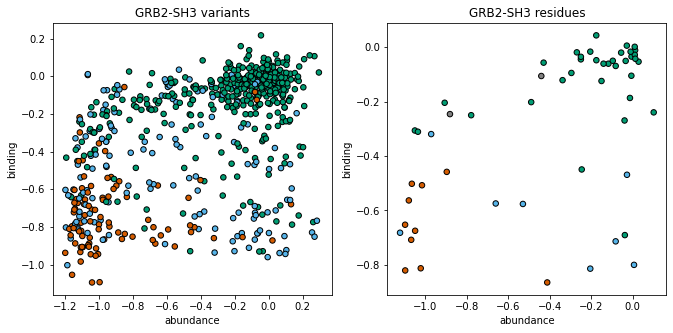

In [226]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,5))

idx = np.isfinite(P62993_fitness_pred_df['abundance'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['binding'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['variant_pred'].to_numpy().flatten())

pos=ax1.scatter(P62993_fitness_pred_df['abundance'].to_numpy().flatten()[idx],P62993_fitness_pred_df['binding'].to_numpy().flatten()[idx],c=P62993_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],s=30,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"]), edgecolor='k')

ax1.set_xlabel('abundance')
ax1.set_ylabel('binding')

# ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
# ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax1.set_title('GRB2-SH3 variants')
ax2.set_title('GRB2-SH3 residues')


idx = np.isfinite(P62993_fitness_median_pred_df['abundance'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['binding'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())

pos=ax2.scatter(P62993_fitness_median_pred_df['abundance'].to_numpy().flatten()[idx],P62993_fitness_median_pred_df['binding'].to_numpy().flatten()[idx],c=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],s=30,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00",'gray','gray']), edgecolor='k')

ax2.set_xlabel('abundance')
ax2.set_ylabel('binding')


# ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
# ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

# ax1.set_xscale('log')
# ax1.set_yscale('log')



plt.savefig('./figures/GRB2_SH3__scatters.pdf')

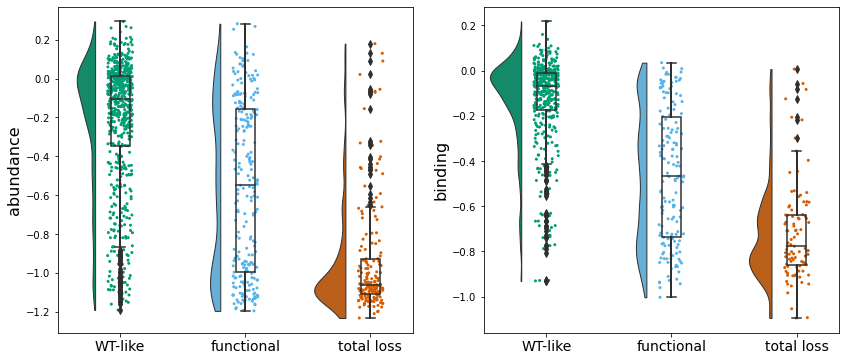

In [227]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(14,6))

idx = np.isfinite(P62993_fitness_pred_df['abundance'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['variant_pred'].to_numpy().flatten())
pt.RainCloud(x=P62993_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],y=P62993_fitness_pred_df['abundance'].to_numpy().flatten()[idx],ax=ax1,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

idx = np.isfinite(P62993_fitness_pred_df['binding'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['variant_pred'].to_numpy().flatten())
pt.RainCloud(x=P62993_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],y=P62993_fitness_pred_df['binding'].to_numpy().flatten()[idx],ax=ax2,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

ax1.set_ylabel('abundance',fontsize=16)

ax2.set_ylabel('binding',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)


plt.savefig('./figures/GRB2_SH3_variant_rainplot.pdf')

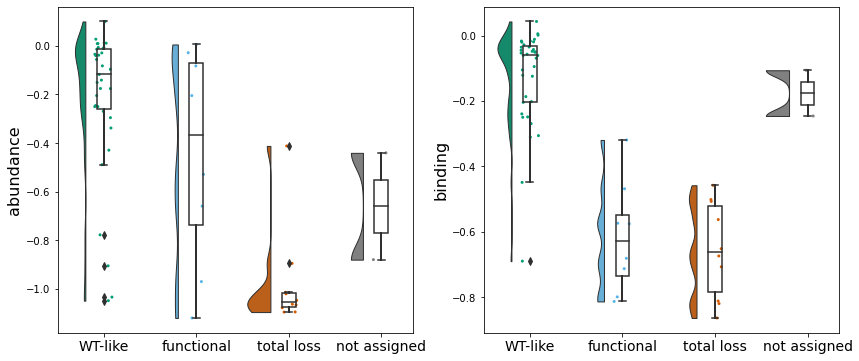

In [228]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(14,6))

idx = np.isfinite(P62993_fitness_median_pred_df['abundance'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pt.RainCloud(x=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],y=P62993_fitness_median_pred_df['abundance'].to_numpy().flatten()[idx],ax=ax1,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00','gray','gray'])

idx = np.isfinite(P62993_fitness_median_pred_df['binding'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pt.RainCloud(x=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],y=P62993_fitness_median_pred_df['binding'].to_numpy().flatten()[idx],ax=ax2,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00','gray','gray'])

ax1.set_ylabel('abundance',fontsize=16)

ax2.set_ylabel('binding',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss','not assigned'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss','not assigned'],fontsize=14)

plt.savefig('./figures/GRB2_SH3_residue_rainplot.pdf')

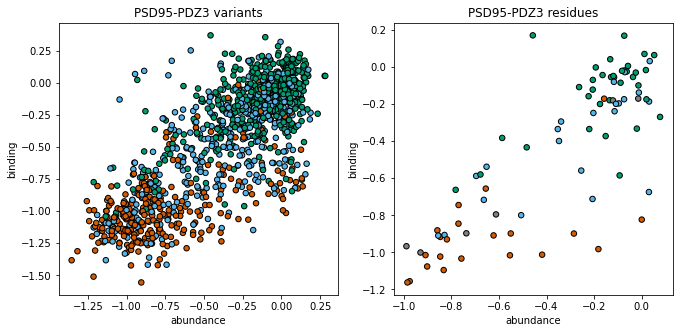

In [590]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,5))

# ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
# ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

ax1.set_title('PSD95-PDZ3 variants')
ax2.set_title('PSD95-PDZ3 residues')
idx = np.isfinite(P78352_fitness_pred_df['abundance'].to_numpy().flatten()) & np.isfinite(P78352_fitness_pred_df['binding'].to_numpy().flatten()) & np.isfinite(P78352_fitness_pred_df['variant_pred'].to_numpy().flatten())

pos=ax1.scatter(P78352_fitness_pred_df['abundance'].to_numpy().flatten()[idx],P78352_fitness_pred_df['binding'].to_numpy()[idx],c=P78352_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],s=30,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"]), edgecolor='k')
ax1.set_xlabel('abundance')
ax1.set_ylabel('binding')


idx = np.isfinite(P78352_fitness_median_pred_df['abundance'].to_numpy().flatten()) & np.isfinite(P78352_fitness_median_pred_df['binding'].to_numpy().flatten()) & np.isfinite(P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten())

pos=ax2.scatter(P78352_fitness_median_pred_df['abundance'].to_numpy().flatten()[idx],P78352_fitness_median_pred_df['binding'].to_numpy()[idx],c=P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],s=30,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00",'gray','gray']), edgecolor='k')
ax2.set_xlabel('abundance')
ax2.set_ylabel('binding')

# ax1.set_xlim(100,np.nanmax(kckm_df['kckm_cmup_G'].to_numpy())*1.2)
# ax1.set_ylim(100,np.nanmax(kckm_df['kckm_cmup_V'].to_numpy())*1.2)

# ax1.set_xscale('log')
# ax1.set_yscale('log')



plt.savefig('./figures/PSD95_PDZ3_scatters_.pdf')

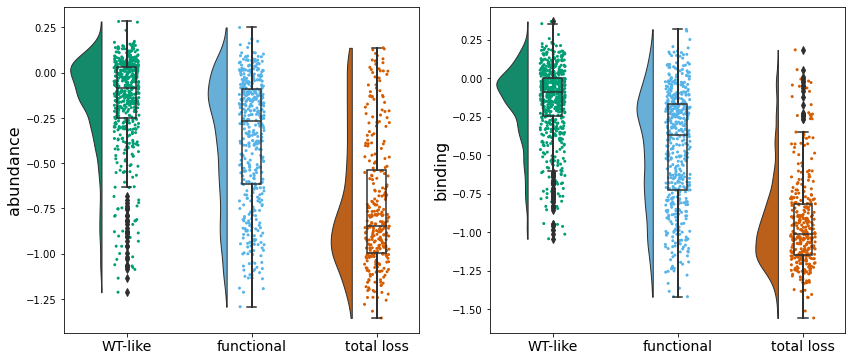

In [230]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(14,6))

idx = np.isfinite(P78352_fitness_pred_df['abundance'].to_numpy().flatten()) & np.isfinite(P78352_fitness_pred_df['variant_pred'].to_numpy().flatten())
pt.RainCloud(x=P78352_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],y=P78352_fitness_pred_df['abundance'].to_numpy().flatten()[idx],ax=ax1,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

idx = np.isfinite(P78352_fitness_pred_df['binding'].to_numpy().flatten()) & np.isfinite(P78352_fitness_pred_df['variant_pred'].to_numpy().flatten())
pt.RainCloud(x=P78352_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],y=P78352_fitness_pred_df['binding'].to_numpy().flatten()[idx],ax=ax2,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

ax1.set_ylabel('abundance',fontsize=16)

ax2.set_ylabel('binding',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)


plt.savefig('./figures/PSD95_PDZ3_variant_rainplot.pdf')

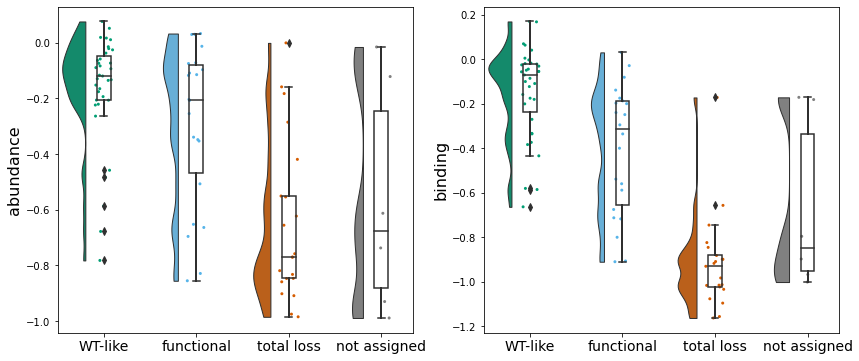

In [231]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(14,6))

idx = np.isfinite(P78352_fitness_median_pred_df['abundance'].to_numpy().flatten()) & np.isfinite(P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pt.RainCloud(x=P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],y=P78352_fitness_median_pred_df['abundance'].to_numpy().flatten()[idx],ax=ax1,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00','gray','gray'])

idx = np.isfinite(P78352_fitness_median_pred_df['binding'].to_numpy().flatten()) & np.isfinite(P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pt.RainCloud(x=P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],y=P78352_fitness_median_pred_df['binding'].to_numpy().flatten()[idx],ax=ax2,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00','gray','gray'])

ax1.set_ylabel('abundance',fontsize=16)

ax2.set_ylabel('binding',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss','not assigned'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss','not assigned'],fontsize=14)

plt.savefig('./figures/PSD95_PDZ3_residue_rainplot.pdf')

### fitted data

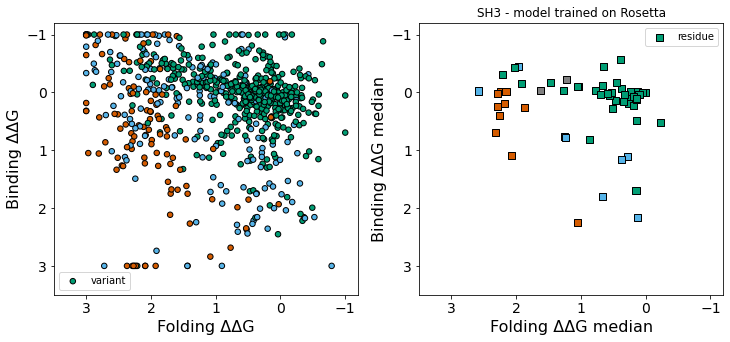

In [717]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

idx = np.isfinite(P62993_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['binding_ddg_norm'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['variant_pred'].to_numpy().flatten())

pos=ax1.scatter(P62993_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()[idx],P62993_fitness_pred_df['binding_ddg_norm'].to_numpy().flatten()[idx],c=P62993_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],s=30,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"]), edgecolor='k',label='variant')




idx = np.isfinite(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())

pos=ax2.scatter(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()[idx],c=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00",'gray','gray']), edgecolor='k',marker='s',label='residue')


ax1.set_xlabel('Folding \u0394\u0394G',fontsize=16)
ax1.set_ylabel('Binding \u0394\u0394G',fontsize=16)

ax2.set_xlabel('Folding \u0394\u0394G median',fontsize=16)
ax2.set_ylabel('Binding \u0394\u0394G median',fontsize=16)

ax1.set_yticks(np.arange(-1,4,1))
ax1.set_xticks(np.arange(-1,4,1))

ax2.set_yticks(np.arange(-1,4,1))
ax2.set_xticks(np.arange(-1,4,1))

ax1.set_xlim(3.5,-1.2)
ax1.set_ylim(3.5,-1.2)

ax2.set_xlim(3.5,-1.2)
ax2.set_ylim(3.5,-1.2)

ax1.legend()
ax2.legend()
ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

# ax1.set_xscale('log')
# ax1.set_yscale('log')

plt.title('SH3 - model trained on Rosetta')

plt.savefig('./figures/Rosetta_GRB2_SH3_ddg_pred_scatters.pdf')

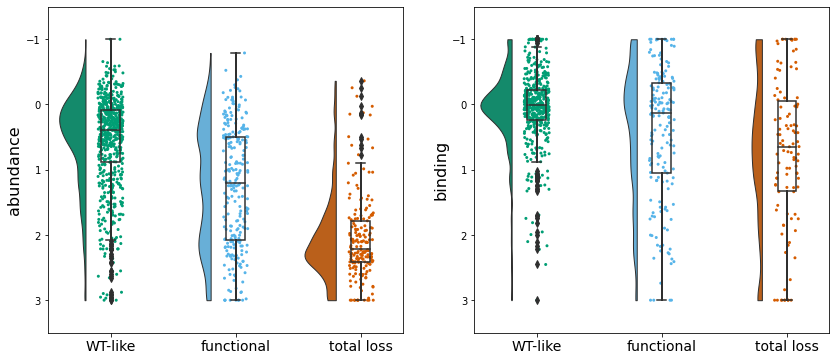

In [607]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(14,6))

idx = np.isfinite(P62993_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['variant_pred'].to_numpy().flatten())
pt.RainCloud(x=P62993_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],y=P62993_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()[idx],ax=ax1,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

idx = np.isfinite(P62993_fitness_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['variant_pred'].to_numpy().flatten())
pt.RainCloud(x=P62993_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],y=P62993_fitness_pred_df['binding_ddg_norm'].to_numpy().flatten()[idx],ax=ax2,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

ax1.set_ylabel('abundance',fontsize=16)

ax2.set_ylabel('binding',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)

ax1.set_ylim(3.5,-1.5)
ax2.set_ylim(3.5,-1.5)

plt.savefig('./figures/GRB2_SH3_ddg_variant_ddg_pred_rainplot.pdf')

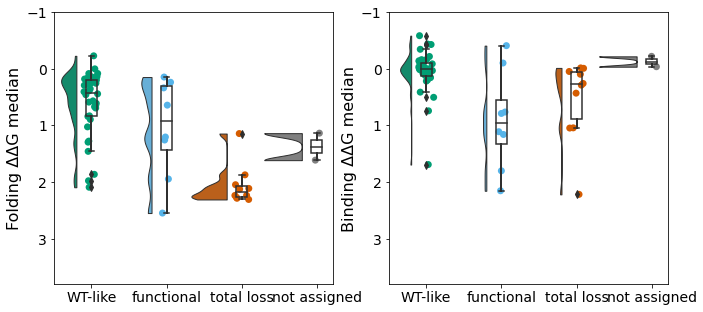

In [987]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(11,5))

idx = np.isfinite(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pt.RainCloud(x=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],y=P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],ax=ax1,orient='v',width_viol=1,palette=['#009e74','#56b4e9','#d55c00','gray','gray'],point_size=7)

idx = np.isfinite(P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pt.RainCloud(x=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],y=P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()[idx],ax=ax2,orient='v',width_viol=1,palette=['#009e74','#56b4e9','#d55c00','gray','gray'],point_size=7)

ax1.set_ylabel('Folding \u0394\u0394G median',fontsize=16)

ax2.set_ylabel('Binding \u0394\u0394G median',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss','not assigned'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss','not assigned'],fontsize=14)

ax1.set_ylim(3.8,-1)
ax2.set_ylim(3.8,-1)

ax1.set_yticks(np.arange(-1,4,1))
ax2.set_yticks(np.arange(-1,4,1))

ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

plt.savefig('./figures/GRB2_SH3_ddg_residue_rainplot.pdf')

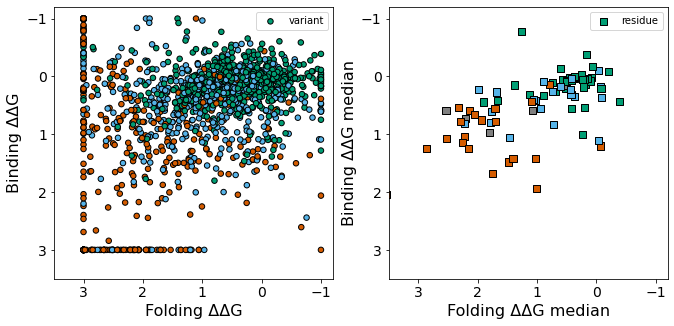

In [954]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(11,5))


idx = np.isfinite(P78352_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()) & np.isfinite(P78352_fitness_pred_df['binding_ddg_norm'].to_numpy().flatten()) & np.isfinite(P78352_fitness_pred_df['variant_pred'].to_numpy().flatten())
pos=ax1.scatter(P78352_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()[idx],P78352_fitness_pred_df['binding_ddg_norm'].to_numpy()[idx],c=P78352_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],s=30,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"]), edgecolor='k',label='variant')



idx = np.isfinite(P78352_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P78352_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pos=ax2.scatter(P78352_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],P78352_fitness_median_pred_df['binding_ddg'].to_numpy()[idx],c=P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00",'gray','gray']), edgecolor='k',marker='s',label='residue')


ax1.set_xlabel('Folding \u0394\u0394G',fontsize=16)
ax1.set_ylabel('Binding \u0394\u0394G',fontsize=16)

ax2.set_xlabel('Folding \u0394\u0394G median',fontsize=16)
ax2.set_ylabel('Binding \u0394\u0394G median',fontsize=16)

ax1.set_yticks(np.arange(-1,4,1))
ax1.set_xticks(np.arange(-1,4,1))

ax2.set_yticks(np.arange(-1,4,1))
ax2.set_xticks(np.arange(-1,4,1))

ax1.set_xlim(3.5,-1.2)
ax1.set_ylim(3.5,-1.2)

ax2.set_xlim(3.5,-1.2)
ax2.set_ylim(3.5,-1.2)

ax1.legend()
ax2.legend()
ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)



plt.savefig('./figures/PSD95_PDZ3_ddg_scatters_.pdf')

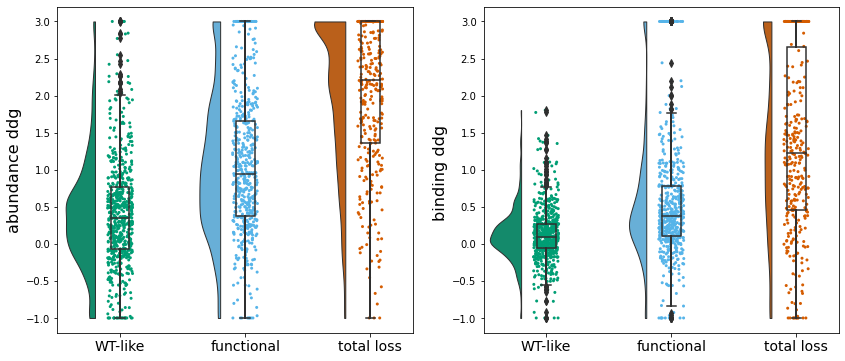

In [844]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(14,6))

idx = np.isfinite(P78352_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()) & np.isfinite(P78352_fitness_pred_df['variant_pred'].to_numpy().flatten())
pt.RainCloud(x=P78352_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],y=P78352_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()[idx],ax=ax1,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

idx = np.isfinite(P78352_fitness_pred_df['binding_ddg_norm'].to_numpy().flatten()) & np.isfinite(P78352_fitness_pred_df['variant_pred'].to_numpy().flatten())
pt.RainCloud(x=P78352_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx],y=P78352_fitness_pred_df['binding_ddg_norm'].to_numpy().flatten()[idx],ax=ax2,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00'])

ax1.set_ylabel('abundance ddg',fontsize=16)

ax2.set_ylabel('binding ddg ',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss'],fontsize=14)


plt.savefig('./figures/PSD95_PDZ3_ddg_variant_rainplot.pdf')

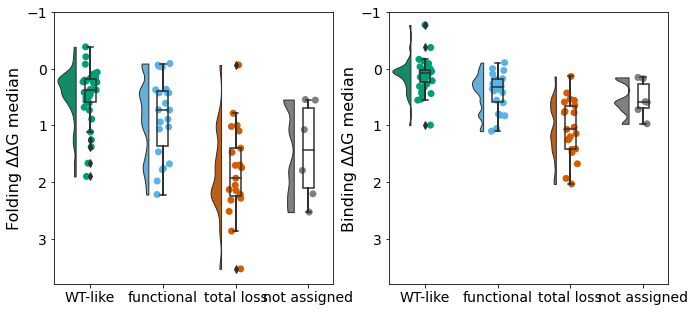

In [986]:
fig,((ax1),(ax2))=plt.subplots(1,2,figsize=(11,5))

idx = np.isfinite(P78352_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pt.RainCloud(x=P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],y=P78352_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],ax=ax1,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00','gray','gray'],point_size=7)

idx = np.isfinite(P78352_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pt.RainCloud(x=P78352_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],y=P78352_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()[idx],ax=ax2,orient='v',width_viol=0.5,palette=['#009e74','#56b4e9','#d55c00','gray','gray'],point_size=7)

ax1.set_ylabel('Folding \u0394\u0394G median',fontsize=16)

ax2.set_ylabel('Binding \u0394\u0394G median',fontsize=16)

ax1.set_xticklabels(['WT-like','functional','total loss','not assigned'],fontsize=14)
ax2.set_xticklabels(['WT-like','functional','total loss','not assigned'],fontsize=14)

ax1.set_ylim(3.8,-1)
ax2.set_ylim(3.8,-1)

ax1.set_yticks(np.arange(-1,4,1))
ax2.set_yticks(np.arange(-1,4,1))

ax1.tick_params(axis='y', labelsize=14)
ax2.tick_params(axis='y', labelsize=14)

plt.savefig('./figures/PSD95_PDZ3_ddg_residue_rainplot.pdf')

### RaSP comparison

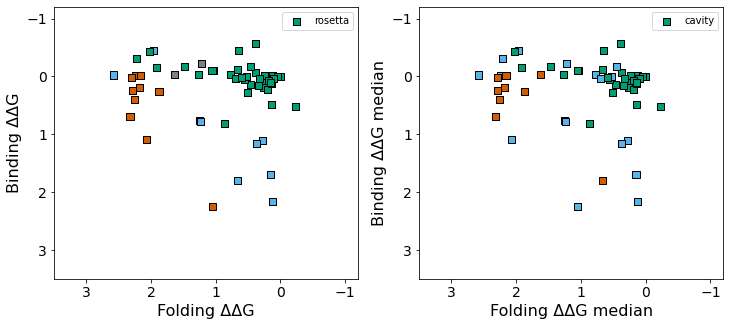

In [ ]:
fig,((ax1,ax2))=plt.subplots(1,2,figsize=(12,5))

idx = np.isfinite(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pos=ax1.scatter(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()[idx],c=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00",'gray','gray']), edgecolor='k',marker='s',label='rosetta')

idx = np.isfinite(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten())
pos=ax2.scatter(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()[idx],c=P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"]), edgecolor='k',marker='s',label='cavity')

ax1.set_xlabel('Folding \u0394\u0394G',fontsize=16)
ax1.set_ylabel('Binding \u0394\u0394G',fontsize=16)

ax2.set_xlabel('Folding \u0394\u0394G median',fontsize=16)
ax2.set_ylabel('Binding \u0394\u0394G median',fontsize=16)

ax1.set_yticks(np.arange(-1,4,1))
ax1.set_xticks(np.arange(-1,4,1))

ax2.set_yticks(np.arange(-1,4,1))
ax2.set_xticks(np.arange(-1,4,1))

ax1.set_xlim(3.5,-1.2)
ax1.set_ylim(3.5,-1.2)

ax2.set_xlim(3.5,-1.2)
ax2.set_ylim(3.5,-1.2)

ax1.legend()
ax2.legend()
ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

# ax1.set_xscale('log')
# ax1.set_yscale('log')



#plt.savefig('./figures/GRB2_SH3_ddg_pred_scatters.pdf')

## Statistic predictions

### model

In [556]:
from sklearn import metrics

# True values
idx = np.isfinite(P62993_fitness_pred_df['exp_variant_class'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['variant_pred'].to_numpy().flatten())

# Predicted values
y_true=P62993_fitness_pred_df['exp_variant_class'].to_numpy().flatten()[idx]
y_pred=P62993_fitness_pred_df['variant_pred'].to_numpy().flatten()[idx]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[339  45   2]
 [ 22  37   5]
 [ 93 114  96]]
              precision    recall  f1-score   support

         0.0      0.747     0.878     0.807       386
         1.0      0.189     0.578     0.285        64
         2.0      0.932     0.317     0.473       303

    accuracy                          0.627       753
   macro avg      0.623     0.591     0.522       753
weighted avg      0.774     0.627     0.628       753



In [557]:
from sklearn import metrics

# True values
idx = np.isfinite(P62993_fitness_median_pred_df['exp_residue_class'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())

# Predicted values
y_true=P62993_fitness_median_pred_df['exp_residue_class'].to_numpy().flatten()[idx]
y_pred=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[28  0  0  0]
 [ 0  5  0  0]
 [ 7  4 10  2]
 [ 0  0  0  0]]
              precision    recall  f1-score   support

         0.0      0.800     1.000     0.889        28
         1.0      0.556     1.000     0.714         5
         2.0      1.000     0.435     0.606        23
         5.0      0.000     0.000     0.000         0

    accuracy                          0.768        56
   macro avg      0.589     0.609     0.552        56
weighted avg      0.860     0.768     0.757        56



###  model with rasp instead of rosetta

In [ ]:
# True values
idx = np.isfinite(P62993_fitness_median_pred_df['exp_residue_class'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten())

# Predicted values
y_true=P62993_fitness_median_pred_df['exp_residue_class'].to_numpy().flatten()[idx]
y_pred=P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten()[idx]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[24  4  0]
 [ 0  4  1]
 [ 6  9  8]]
              precision    recall  f1-score   support

         0.0      0.800     0.857     0.828        28
         1.0      0.235     0.800     0.364         5
         2.0      0.889     0.348     0.500        23

    accuracy                          0.643        56
   macro avg      0.641     0.668     0.564        56
weighted avg      0.786     0.643     0.652        56



## RaSP-trained model predictions

In [124]:
cat=CatBoostClassifier(iterations=2500, random_strength= 1, depth= 7, l2_leaf_reg= 9, bagging_temperature= 2,verbose=0,class_weights={0:1,1:2,2:1,3:0.1})

In [125]:
cat.load_model('../catboost_model/cat_gemme_af_cavity_13apr23.cbm')

###  P62993 predictions

In [622]:
P62993_X,P62993_map=features_validation([P62993_GEMME,P62993_rosetta_ddg_norm, P62993_GEMME_mean, P62993_rosetta_ddg_mean, P62993_hydrophobicity_mut,P62993_GEMME_neigbor_scores,P62993_rosetta_neigbor_scores,P62993_wcn],P62993_WT_sequence)

In [623]:
len(P62993_WT_sequence)

217

In [624]:
prediction=cat.predict(P62993_X)

In [625]:
P62993_variant_pred=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_variant_pred[:]=np.nan

for i,(n,m) in enumerate(zip(P62993_map,prediction)):
    P62993_variant_pred[n[0],n[1]]=m

In [626]:
P62993_3mode_prediction,percentage=retrieve_residue_label_pred(prediction,P62993_map,P62993_WT_sequence,0.50)

In [627]:
count=0
for i in prediction:
    if i==1:
        count+=1
print(count)

1004


In [628]:
count=0
for i in prediction:
    if i==2:
        count+=1
print(count)

871


In [629]:
count=0
for i,n in enumerate(P62993_3mode_prediction):
    if n==1:
        print(P62993_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

M1, E2, F9, T12, F19, R21, G22, W36, E40, G43, G46, F47, P49, Y52, I53, R67, R86, S88, S90, G93, S96, S98, K100, K109, D113, G116, R142, N143, F147, Q162, E171, E174, G180, C198, P206, 35


In [630]:
count=0
for i,n in enumerate(P62993_3mode_prediction):
    if n==0:
        print(P62993_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

I4, K6, Y7, D8, K10, A11, A13, D14, D15, S18, K20, D23, I24, K26, L28, N29, E30, E31, C32, D33, Q34, N35, Y37, K38, L41, N42, K44, D45, K50, N51, E54, M55, K56, P57, H58, P59, F62, K64, P66, A68, K69, E72, M73, S75, K76, Q77, R78, H79, D80, E87, E89, A91, P92, D94, F101, G102, N103, D104, Q106, L111, R112, G114, A115, K117, W121, V122, V123, N126, N129, E130, D133, Y134, S137, T138, S141, Q144, Q145, R149, I151, E152, Q153, V154, P155, Q156, Q157, P158, T159, Y160, L164, F165, D166, D168, P169, Q170, D172, G173, G176, R178, R179, D181, F182, H184, M186, D187, N188, S189, D190, P191, N192, K195, A197, H199, G200, Q201, T202, M204, R207, N208, T211, P212, V213, N214, R215, N216, V217, 125


###  P62993 cavity predictions

In [682]:
P62993_cavity_X,P62993_cavity_map=features_validation([P62993_GEMME,P62993_cavity_ddg_norm, P62993_GEMME_mean, P62993_cavity_ddg_mean, P62993_hydrophobicity_mut,P62993_GEMME_neigbor_scores,P62993_cavity_neigbor_scores,P62993_wcn],P62993_WT_sequence)

In [683]:
len(P62993_WT_sequence)

217

In [684]:
prediction=cat.predict(P62993_cavity_X)

In [685]:
P62993_variant_cavity_pred=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_variant_cavity_pred[:]=np.nan

for i,(n,m) in enumerate(zip(P62993_cavity_map,prediction)):
    P62993_variant_cavity_pred[n[0],n[1]]=m

In [686]:
P62993_3mode_cavity_prediction,percentage=retrieve_residue_label_pred(prediction,P62993_cavity_map,P62993_WT_sequence,0.50)

In [687]:
count=0
for i in prediction:
    if i==1:
        count+=1
print(count)

1027


In [688]:
count=0
for i in prediction:
    if i==2:
        count+=1
print(count)

717


In [689]:
count=0
for i,n in enumerate(P62993_3mode_cavity_prediction):
    if n==1:
        print(P62993_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

M1, E2, T12, E16, G22, L28, E40, L41, P49, Y52, E71, R86, S88, G93, S98, K100, H107, K109, D113, W121, S127, N129, H135, R136, R142, F147, F165, D166, E174, G180, W193, P206, Y209, 33


In [690]:
count=0
for i,n in enumerate(P62993_3mode_cavity_prediction):
    if n==0:
        print(P62993_WT_sequence[i],i+1,", ",sep="",end="")   
        count+=1
print(count)

I4, K6, Y7, D8, K10, A11, A13, D14, D15, S18, K20, R21, D23, I24, K26, N29, E30, E31, C32, D33, Q34, N35, K38, N42, G43, K44, D45, F47, K50, N51, E54, M55, K56, P57, H58, P59, F62, G63, K64, P66, R67, A68, K69, E72, M73, S75, K76, Q77, R78, H79, D80, E87, E89, S90, A91, P92, D94, S96, G102, N103, D104, Q106, L111, R112, G114, A115, G116, K117, V122, V123, K124, N126, E130, D133, S137, T138, S139, S141, N143, Q144, Q145, R149, D150, E152, Q153, V154, P155, Q156, Q157, P158, T159, Y160, Q162, L164, D168, P169, Q170, E171, D172, G173, G176, R178, R179, D181, F182, H184, M186, D187, N188, S189, D190, P191, N192, K195, A197, C198, H199, G200, Q201, T202, M204, R207, N208, T211, P212, V213, N214, R215, N216, V217, 130


### p62993 df rasp

In [691]:
idx = np.isfinite(P62993_abundance.flatten()) | np.isfinite(P62993_binding.flatten())
np.count_nonzero(~np.isnan(P62993_abundance[:]))

1034

In [692]:
P62993_fitness_pred_df=pd.DataFrame({'residue_class': np.tile(P62993_3mode_prediction.flatten(),(1,20)).flatten()[idx],
                    'residue_cavity_class': np.tile(P62993_3mode_cavity_prediction.flatten(),(1,20)).flatten()[idx],
                    'variant_cavity_pred':P62993_variant_cavity_pred.flatten()[idx],
                    'variant_pred':P62993_variant_pred.flatten()[idx],'abundance':P62993_abundance.flatten()[idx],'binding':P62993_binding.flatten()[idx],
                     'abundance_ddg':P62993_abundance_ddg.flatten()[idx],'binding_ddg':P62993_binding_ddg.flatten()[idx],
                    'abundance_ddg_norm':P62993_abundance_ddg_norm.flatten()[idx],'binding_ddg_norm':P62993_binding_ddg_norm.flatten()[idx],
                    'exp_variant_class': P62993_exp_variant_label.flatten()[idx]
                    })

In [693]:
idx = np.isfinite(P62993_abundance_median.flatten()) | np.isfinite(P62993_binding_median.flatten())
np.count_nonzero(~np.isnan(P62993_abundance_median[:]))

55

In [694]:
P62993_fitness_median_pred_df=pd.DataFrame({'residue_class':P62993_3mode_prediction.flatten()[idx],
                    'residue_cavity_class':P62993_3mode_cavity_prediction.flatten()[idx],
                    'residue_coevo_ddg':P62993_coevo_ddg_mode_value.flatten()[idx],
                    'residue_coevo_ddg_rasp':P62993_coevo_ddg_mode_value_rasp.flatten()[idx],
                    'abundance':P62993_abundance_median.flatten()[idx],'binding':P62993_binding_median.flatten()[idx],
                    'abundance_ddg':P62993_abundance_ddg_median.flatten()[idx],'binding_ddg':P62993_binding_ddg_median.flatten()[idx], 
                    'exp_residue_class': P62993_exp_residue_label.flatten()[idx],
                    'concavity': P62993_concavity_scores[idx], 'itassel': P62993_itassel_scores[idx],
                    'p2rank_prob': (P62993_p2rank[:,0])[idx],'p2rank_cluster': (P62993_p2rank[:,1])[idx]
                    })

### rasp predcition

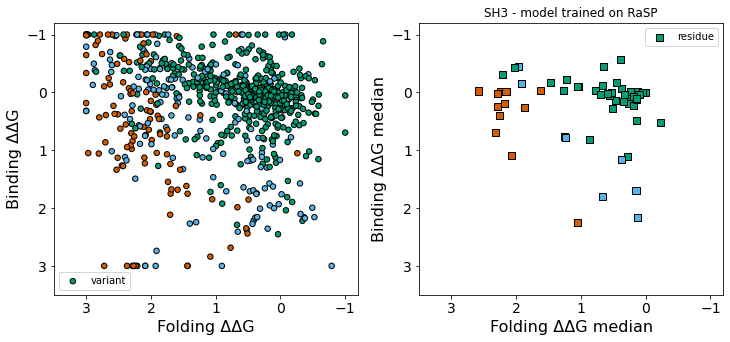

In [697]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

idx = np.isfinite(P62993_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['binding_ddg_norm'].to_numpy().flatten()) & np.isfinite(P62993_fitness_pred_df['variant_cavity_pred'].to_numpy().flatten())

pos=ax1.scatter(P62993_fitness_pred_df['abundance_ddg_norm'].to_numpy().flatten()[idx],P62993_fitness_pred_df['binding_ddg_norm'].to_numpy().flatten()[idx],c=P62993_fitness_pred_df['variant_cavity_pred'].to_numpy().flatten()[idx],s=30,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"]), edgecolor='k',label='variant')




idx = np.isfinite(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten())

pos=ax2.scatter(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()[idx],c=P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"]), edgecolor='k',marker='s',label='residue')


ax1.set_xlabel('Folding \u0394\u0394G',fontsize=16)
ax1.set_ylabel('Binding \u0394\u0394G',fontsize=16)

ax2.set_xlabel('Folding \u0394\u0394G median',fontsize=16)
ax2.set_ylabel('Binding \u0394\u0394G median',fontsize=16)

ax1.set_yticks(np.arange(-1,4,1))
ax1.set_xticks(np.arange(-1,4,1))

ax2.set_yticks(np.arange(-1,4,1))
ax2.set_xticks(np.arange(-1,4,1))

ax1.set_xlim(3.5,-1.2)
ax1.set_ylim(3.5,-1.2)

ax2.set_xlim(3.5,-1.2)
ax2.set_ylim(3.5,-1.2)

ax1.legend()
ax2.legend()
ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

# ax1.set_xscale('log')
# ax1.set_yscale('log')

plt.title('SH3 - model trained on RaSP')

plt.savefig('./figures/RaSP_model_GRB2_SH3_ddg_pred_scatters.pdf')

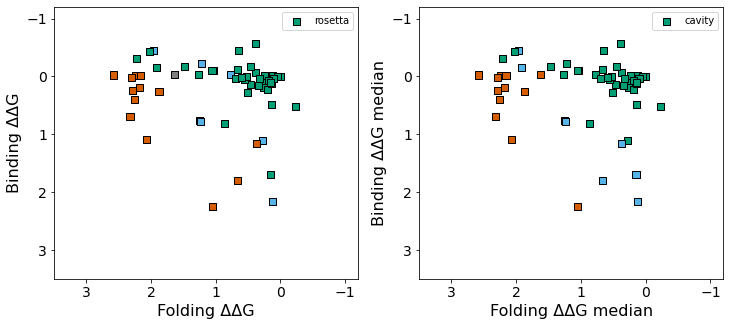

In [645]:
fig,((ax1,ax2))=plt.subplots(1,2,figsize=(12,5))

idx = np.isfinite(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())
pos=ax1.scatter(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()[idx],c=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00",'gray','gray']), edgecolor='k',marker='s',label='rosetta')

idx = np.isfinite(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten())
pos=ax2.scatter(P62993_fitness_median_pred_df['abundance_ddg'].to_numpy().flatten()[idx],P62993_fitness_median_pred_df['binding_ddg'].to_numpy().flatten()[idx],c=P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten()[idx],s=50,cmap=mpl.colors.ListedColormap(["#009e74","#56b4e9","#d55c00"]), edgecolor='k',marker='s',label='cavity')

ax1.set_xlabel('Folding \u0394\u0394G',fontsize=16)
ax1.set_ylabel('Binding \u0394\u0394G',fontsize=16)

ax2.set_xlabel('Folding \u0394\u0394G median',fontsize=16)
ax2.set_ylabel('Binding \u0394\u0394G median',fontsize=16)

ax1.set_yticks(np.arange(-1,4,1))
ax1.set_xticks(np.arange(-1,4,1))

ax2.set_yticks(np.arange(-1,4,1))
ax2.set_xticks(np.arange(-1,4,1))

ax1.set_xlim(3.5,-1.2)
ax1.set_ylim(3.5,-1.2)

ax2.set_xlim(3.5,-1.2)
ax2.set_ylim(3.5,-1.2)

ax1.legend()
ax2.legend()
ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

# ax1.set_xscale('log')
# ax1.set_yscale('log')



#plt.savefig('./figures/GRB2_SH3_ddg_pred_scatters.pdf')

In [646]:
from sklearn import metrics

# True values
idx = np.isfinite(P62993_fitness_median_pred_df['exp_residue_class'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten())

# Predicted values
y_true=P62993_fitness_median_pred_df['exp_residue_class'].to_numpy().flatten()[idx]
y_pred=P62993_fitness_median_pred_df['residue_class'].to_numpy().flatten()[idx]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[27  1  0  0]
 [ 1  2  2  0]
 [ 8  3 11  1]
 [ 0  0  0  0]]
              precision    recall  f1-score   support

         0.0      0.750     0.964     0.844        28
         1.0      0.333     0.400     0.364         5
         2.0      0.846     0.478     0.611        23
         5.0      0.000     0.000     0.000         0

    accuracy                          0.714        56
   macro avg      0.482     0.461     0.455        56
weighted avg      0.752     0.714     0.705        56



### rasp

In [647]:
# True values
idx = np.isfinite(P62993_fitness_median_pred_df['exp_residue_class'].to_numpy().flatten()) & np.isfinite(P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten())

# Predicted values
y_true=P62993_fitness_median_pred_df['exp_residue_class'].to_numpy().flatten()[idx]
y_pred=P62993_fitness_median_pred_df['residue_cavity_class'].to_numpy().flatten()[idx]

# Print the confusion matrix
print(metrics.confusion_matrix(y_true, y_pred))

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

[[28  0  0]
 [ 1  4  0]
 [ 8  3 12]]
              precision    recall  f1-score   support

         0.0      0.757     1.000     0.862        28
         1.0      0.571     0.800     0.667         5
         2.0      1.000     0.522     0.686        23

    accuracy                          0.786        56
   macro avg      0.776     0.774     0.738        56
weighted avg      0.840     0.786     0.772        56



In [ ]:
model_name=['coevo_ddg','functional_model','coevo_rasp','functional_RaSP']
precision_SH3_func=[0.400,0.333,0.250,0.600]
recall_SH3_func=[0.400,0.400,0.200,0.800]
F1_SH3_func=[0.400,0.364,0.222,0.611]
precision_SH3=[0.787,0.752,0.730,0.840]
recall_SH3=[0.714,0.714,0.714,0.786]
F1_SH3=[0.716,0.705,0.695,0.780]

In [ ]:
P62993_pd_stats=pd.DataFrame({'precision_funct':precision_SH3_func,'recall_funct':recall_SH3_func,'F1_funct':F1_SH3_func,'precision':precision_SH3,'recall':recall_SH3,'F1':F1_SH3},index=model_name)

In [650]:
P62993_pd_stats_T=P62993_pd_stats.T

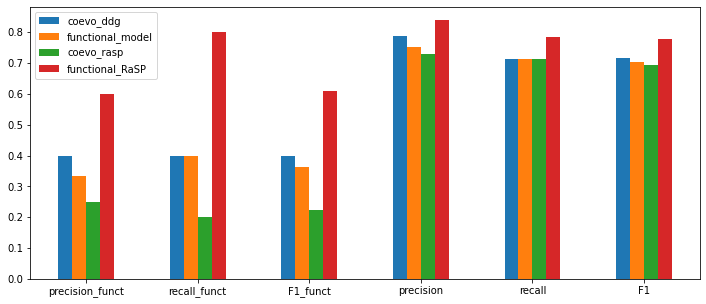

In [651]:
fig,ax1=plt.subplots(1,figsize=(12,5))
P62993_pd_stats_T.plot.bar(rot=0,ax=ax1)
plt.savefig('./Figures/RaSP_trained_SH3_comparison_combinations_coevo_ddg_rasp.pdf')